In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)
# colors = ["#95D3A2", "#FFFFBF", "#F79051", ]
colors = ["#5657A4", "#95D3A2", "#FFFFBF", "#F79051", "#A30644"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

In [10]:
model = GSPatternFormation(0.1, 1.5, boundaryLength=10, cellNumInLine=250, 
                           diffusionRateDc=0.01, productRateK0=2,
                           epsilon=10, c0=0.012, chemoBetaU=10,
                           dt=0.02, shotsnaps=5,
                           tqdm=True)
self = model

In [12]:
%%timeit
self.nabla2V

1.15 ms ± 55.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit
self.update()  # 250

35.2 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit
_distance_wgt_product_c(model.tempDistanceCX, model.alpha, model.productRateK0)

34.6 ms ± 934 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
# %%timeit
model.deltaX

10.6 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
model.run(500)

  0%|          | 0/500 [00:00<?, ?it/s]

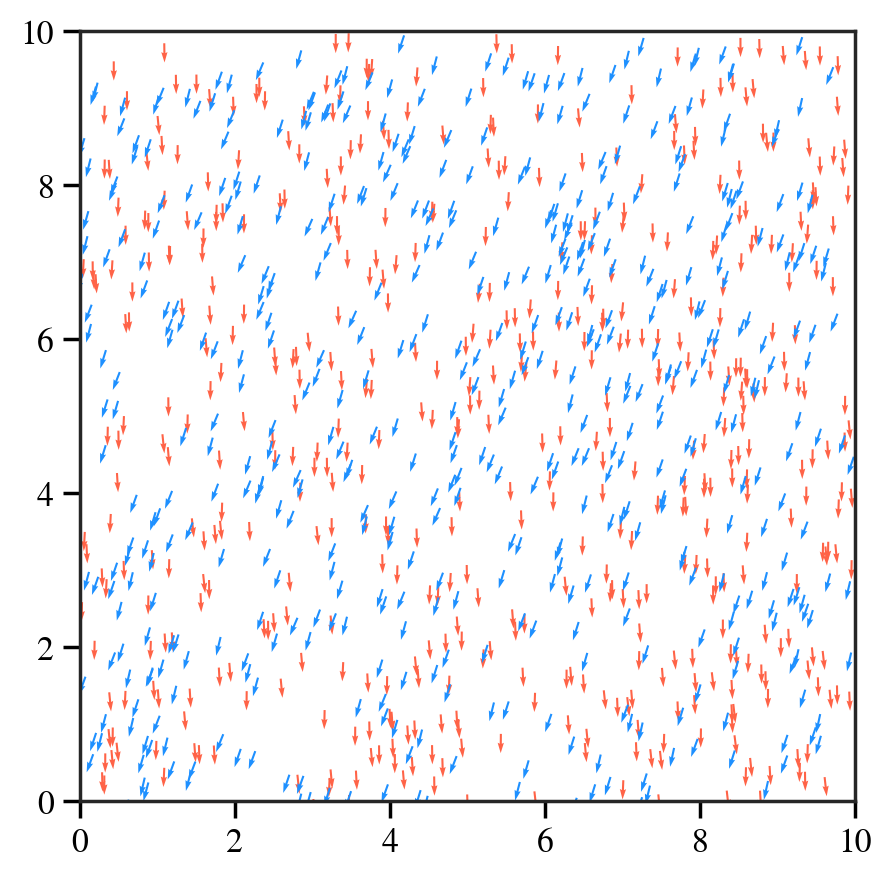

In [4]:
model.plot()

In [ ]:
plt.pcolor(model.c.T, cmap=cmap) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)
plt.show()

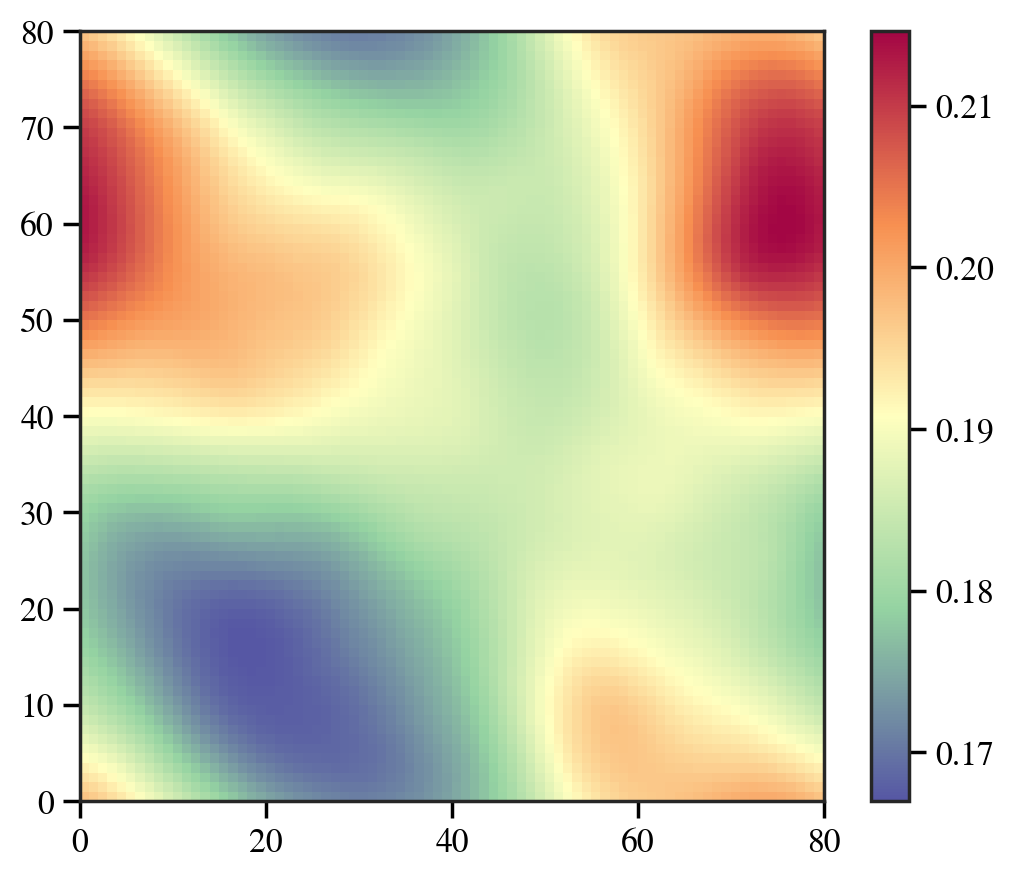

(0.0, 80.0)

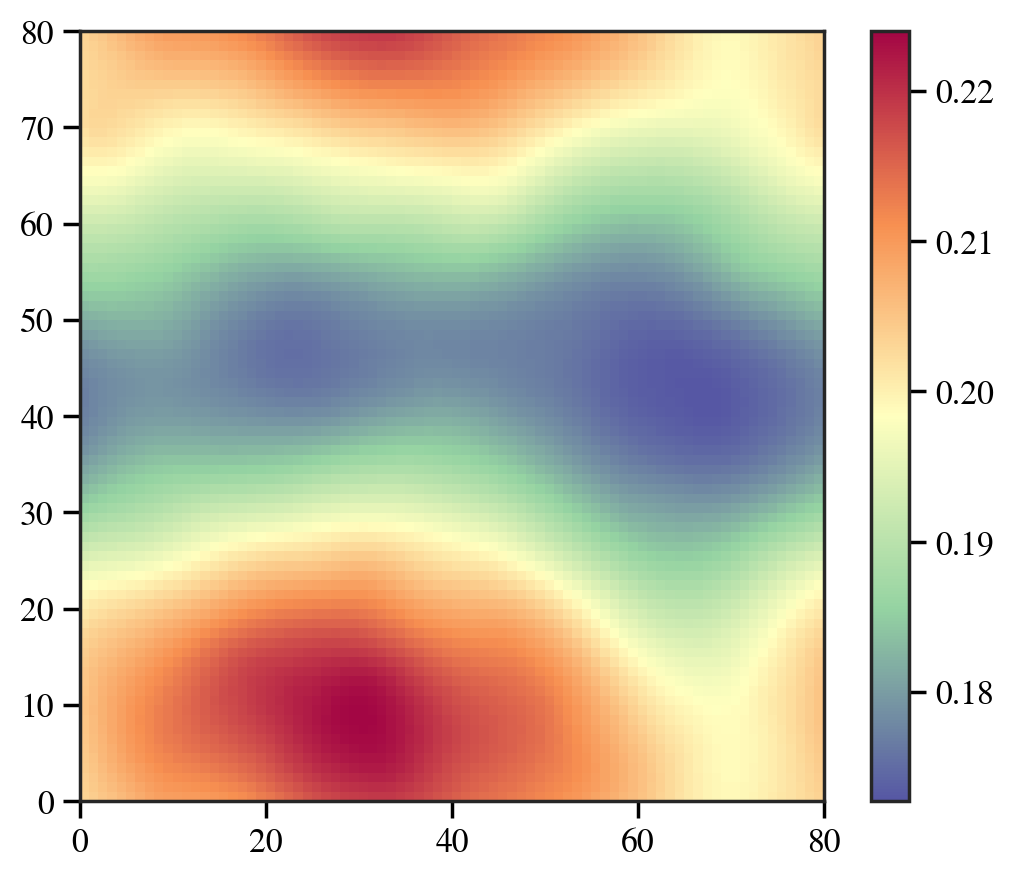

In [ ]:
plt.pcolor(model.u.T, cmap=cmap) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)
plt.show()
plt.pcolor(model.v.T, cmap=cmap) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)

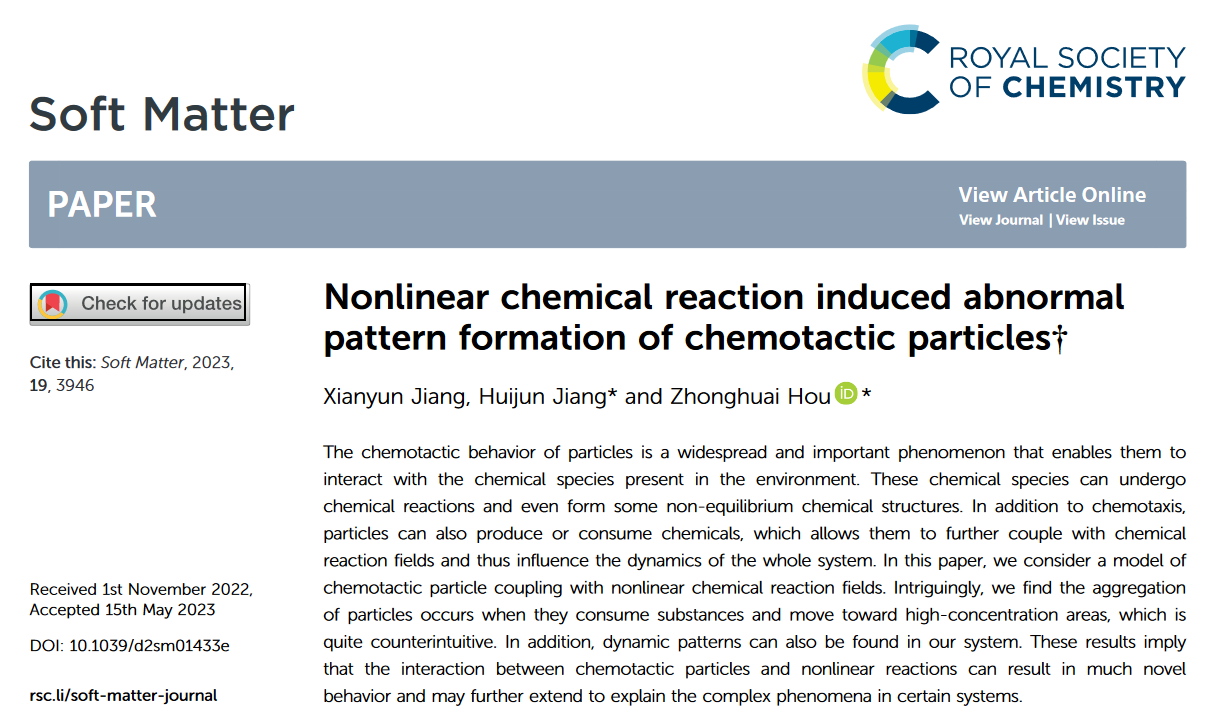
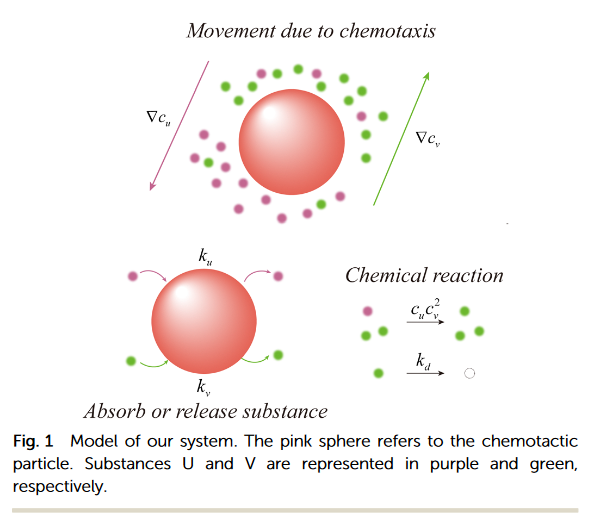
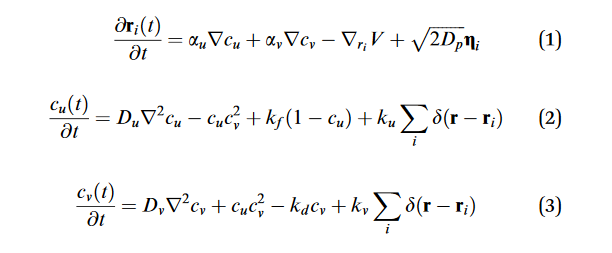

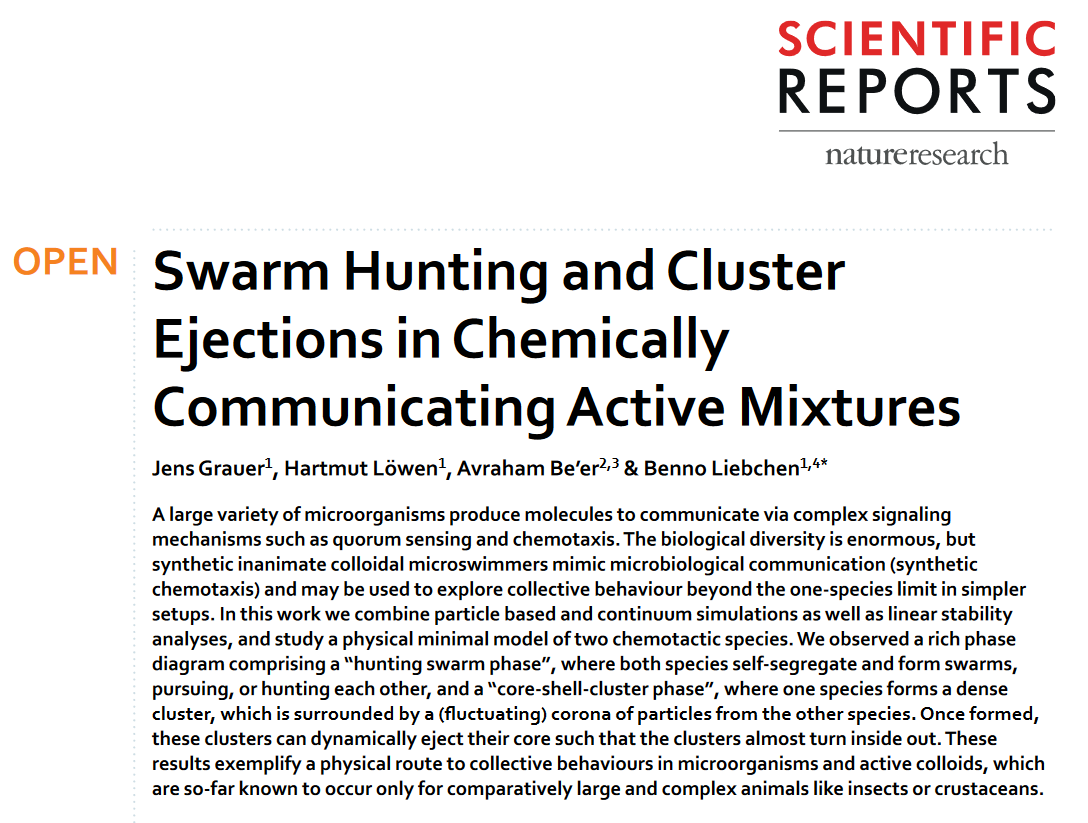
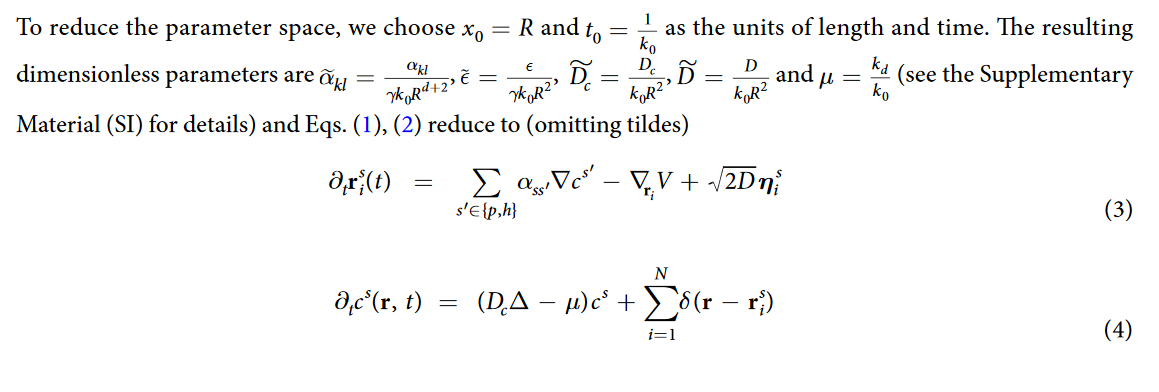

shot 10 2m31s

In [ ]:
alphas = np.concatenate([
    np.arange(0.1, 1, 0.05), np.arange(1, 2.1, 0.5)
])
chemotacticStrengthBetaRs = np.array([0.1, 0.5, 1, 2, 5, 10])

models = [
    PatternFormation(strengthLambda=0.1, alpha=a, chemotacticStrengthBetaR=b,
                     diffusionRateDc=0.01, cellNumInLine=80, epsilon=10, 
                     c0=0.012, tqdm=True, savePath="data", overWrite=True)
    for a, b in product(alphas, chemotacticStrengthBetaRs)
]

len(models)

In [ ]:
# model.update()
# model.plot()
halfNum = model.agentsNum // 2
positionX = model.positionX
phaseTheta = model.phaseTheta
cPosition = model.cPosition.reshape(model.cellNumInLine, model.cellNumInLine, 2)
adjMulti = model.cellNumInLine / model.boundaryLength

plt.quiver(
    positionX[:halfNum, 0] * adjMulti, positionX[:halfNum, 1] * adjMulti,
    np.cos(phaseTheta[:halfNum]), np.sin(phaseTheta[:halfNum]), color="#A30644", zorder=10
)
plt.quiver(
    positionX[halfNum:, 0] * adjMulti, positionX[halfNum:, 1] * adjMulti,
    np.cos(phaseTheta[halfNum:]), np.sin(phaseTheta[halfNum:]), color="#5657A4", zorder=10
)

X = cPosition[:, :, 0].T * adjMulti
Y = cPosition[:, :, 1].T * adjMulti
c = model.c.copy().T
U = np.roll(c, 1, axis=1) - np.roll(c, -1, axis=1)
V = np.roll(c, 1, axis=0) - np.roll(c, -1, axis=0)
plt.streamplot(X, Y, U, V, color="black", linewidth=1, density=2)
# plt.contourf(model.c.T, cmap=cmap, levels=50)
plt.pcolor(model.c.T, cmap=cmap) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)

In [ ]:
plt.pcolor(model.c, cmap='viridis') # , levels=50
plt.colorbar()

In [ ]:
plt.pcolor(model.c, cmap='viridis') # , levels=50
plt.colorbar()
plt.show()
model.plot()

In [ ]:
def my_laplacian(in_array):
    center = -in_array
    direct_neighbors = 0.20 * (
        np.roll(in_array, 1, axis=0)
        + np.roll(in_array, -1, axis=0)
        + np.roll(in_array, 1, axis=1)
        + np.roll(in_array, -1, axis=1)
    )
    diagonal_neighbors = 0.05 * (
        np.roll(np.roll(in_array, 1, axis=0), 1, axis=1)
        + np.roll(np.roll(in_array, -1, axis=0), 1, axis=1)
        + np.roll(np.roll(in_array, -1, axis=0), -1, axis=1)
        + np.roll(np.roll(in_array, 1, axis=0), -1, axis=1)
    )

    out_array = center + direct_neighbors + diagonal_neighbors
    return out_array

In [ ]:
model.close()